# Overview
- 特徴量がある値でサチっているのが気になるのでそれを補正する

# Const

In [1]:
NB = '008'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
PATH_GROUP = '../data_ignore/output_nb/nb004/group.csv'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']

# Import everything I need :)

In [2]:
import os
from pprint import pprint
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# My function

In [3]:
def get_696_strategy_fold(group, n_splits, seed=0):
    '''nb004'''
    
    # group == 0 (all_target=0)の分解
    mask_0 = group['group'] == 0
    group_0 = group[mask_0]
    splitter = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    df_fold_0 = pd.DataFrame()
    df_fold_0['fold'] = np.zeros(len(group_0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_0)):
        df_fold_0['fold'][idx_val] = int(i_fold + 1)

    # group != 0 の分解
    mask_not0 = group['group'] != 0
    group_not0 = group[mask_not0]
    splitter = GroupKFold(n_splits=n_splits)
    df_fold_not0 = pd.DataFrame()
    df_fold_not0['fold'] = np.zeros(len(group_not0)).astype(int)
    for i_fold, (idx_trn, idx_val)  in enumerate(splitter.split(group_not0, groups=group_not0['group'].values)):
        df_fold_not0['fold'][idx_val] = int(i_fold + 1)

    # fold情報の結合
    df_fold = pd.DataFrame()
    df_fold['sig_id'] = group['sig_id'].values
    df_fold['fold'] = np.zeros(len(group)).astype(int)
    df_fold['fold'][mask_0.values] = df_fold_0['fold'].values
    df_fold['fold'][mask_not0.values] = df_fold_not0['fold'].values
    return df_fold

In [4]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(targets.columns):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

# Preparation

set

In [5]:
sns.set()
np.random.seed(seed=0)
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings('ignore')

<br>

load datasets

In [6]:
train_features = pd.read_csv(PATH_TRAIN, index_col='sig_id')
train_targets = pd.read_csv(PATH_TRAIN_SCORED, index_col='sig_id')
# train_nonscored = pd.read_csv(PATH_TRAIN_NONSCORED)
# sub = pd.read_csv(PATH_SUB)
test_features = pd.read_csv(PATH_TEST, index_col='sig_id')

In [7]:
targets = train_targets.copy()
train_features_new = train_features.copy()

In [8]:
train_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

# EDA

すべての特徴量はの最大値最小値は、10と-10となっている

In [9]:
train_features.iloc[:, 3:].describe()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680,g-681,g-682,g-683,g-684

<br>

分布の確認

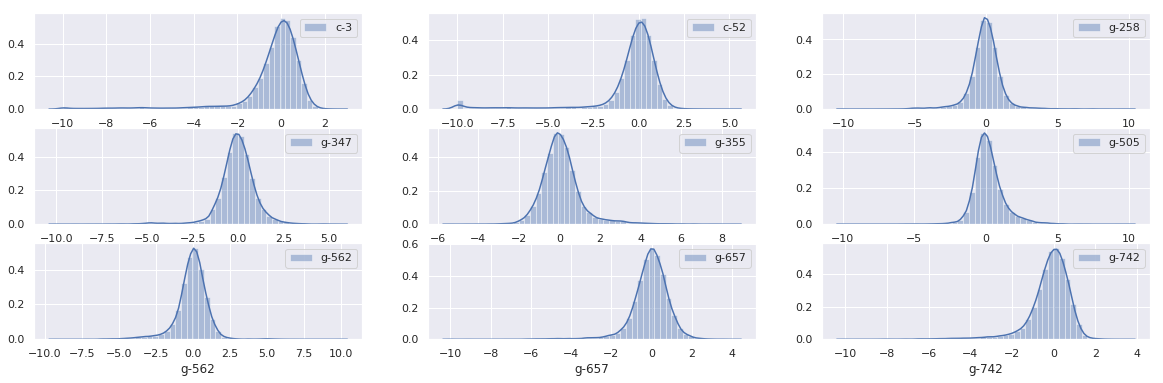

In [10]:
df_random = train_features.iloc[:, 3:].sample(n=9, axis=1, random_state=5).sort_index(axis=1)

fig, axs = plt.subplots(3, 3, figsize=(20, 6))
axs = axs.ravel()
for i, col in enumerate(df_random.columns):
    sns.distplot(df_random[col], ax=axs[i], label=col)
    axs[i].legend()

<br>

-10がどれぐらい入っているか確認

In [188]:
count_10 = np.sum(train_features.iloc[:, 3:]<-9.8, axis=0)
count_10 = count_10.sort_values(ascending=False)

In [191]:
print('-9.8未満がの割合(%)が多い特徴量ランキングtop10')
count_10[:10]/len(train_features)*100

-9.8がの割合(%)が多い特徴量ランキングtop10


c-70     2.880658
c-94     2.809272
c-63     2.792475
c-93     2.746284
c-60     2.729487
c-59     2.590913
c-6      2.469136
g-228    2.443941
c-55     2.418745
c-65     2.288570
dtype: float64

<br>

1位を確認してみる

Text(0.5, 1.0, 'c-70')

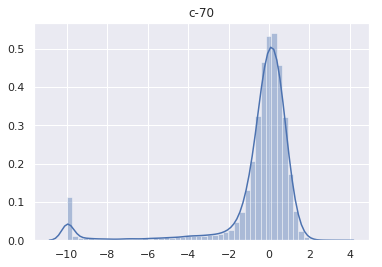

In [192]:
name = count_10.index[0]
sns.distplot(train_features[name].values)
plt.title(name)

---> めっちゃ-10入ってる...

# 3位(c-93)を解析してみる
- 3位: c-93

Text(0.5, 1.0, 'c-63')

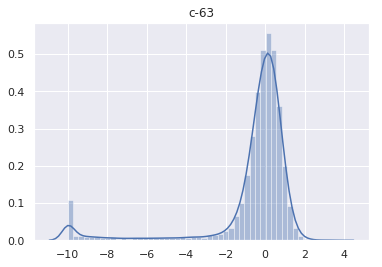

In [193]:
name = count_10.index[2]
mask_m10 = train_features[name] < -9.8
n_m10 = np.sum(mask_m10)

sns.distplot(train_features[name].values)
plt.title(name)

<br>

-10付近の確認

Text(0.5, 1.0, 'c-63')

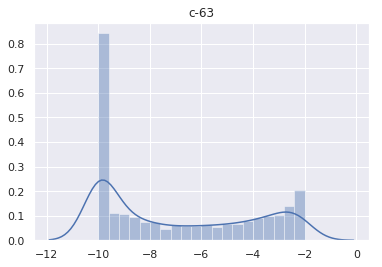

In [194]:
mask = train_features[name].values < -2
feat_mask = train_features[name][mask]
sns.distplot(feat_mask.values, bins=20)
plt.title(name)

<br>

この-10を自然な感じにしたい

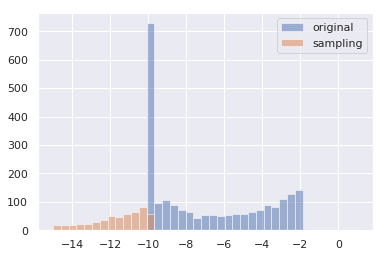

In [195]:
lam = 0.3
rand = rd.exponential(1./lam, size=n_m10)
rand_ = -rand - 9.8
range_bin_width = np.linspace(-15, 1, 40)
# sns.distplot(feat_mask.values, bins=range_bin_width, kde=False, label='original')
# sns.distplot(rand_, bins=range_bin_width, kde=False, label='sampling')
plt.hist(feat_mask.values, bins=range_bin_width, label='original', alpha=0.5)
plt.hist(rand_, bins=range_bin_width, label='sampling', alpha=0.5)
plt.legend()

<br>

sampling値に置き換え

In [196]:
train_features_new[name][mask_m10] = rand_

(0, 500)

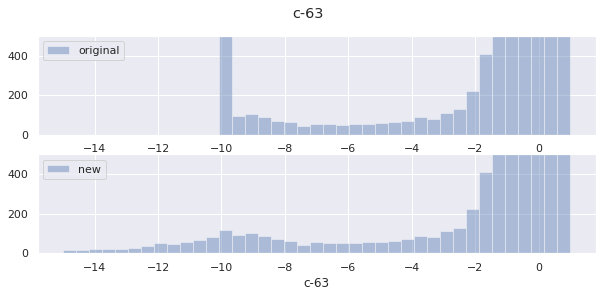

In [199]:
mask = train_features[name] < 1
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
fig.suptitle(name)

sns.distplot(train_features[name][mask], kde=False, bins=range_bin_width, ax=axs[0], label='original')
axs[0].legend(loc='upper left')
axs[0].set_ylim(0, 500)
sns.distplot(train_features_new[name][mask], kde=False, bins=range_bin_width, ax=axs[1], label='new')
axs[1].legend(loc='upper left')
axs[1].set_ylim(0, 500)

---> いい感じ！！

# Summary
- 置き換える関数作る

In [269]:
def add_exp_noise(df_feat, low_val=-9.8, high_val=9.8):
    _df_feat = df_feat.copy()
    lam = 0.3
    for name in progress_bar(_df_feat.columns):
        mask_low = _df_feat[name] < low_val
        n_low = np.sum(mask_low)
        rand = rd.exponential(1./lam, size=n_low)
        rand_ = -rand - low_val
        _df_feat[name][mask_low] = rand_
        
        mask_high = _df_feat[name] > high_val
        n_high = np.sum(mask_high)
        rand = rd.exponential(1./lam, size=n_high)
        rand_ = rand + high_val
        _df_feat[name][mask_high] = rand_
    return _df_feat

In [270]:
df = add_exp_noise(train_features.iloc[:, 3:], low_val=-9.8, high_val=9.8)

<br>

可視化

(0, 500)

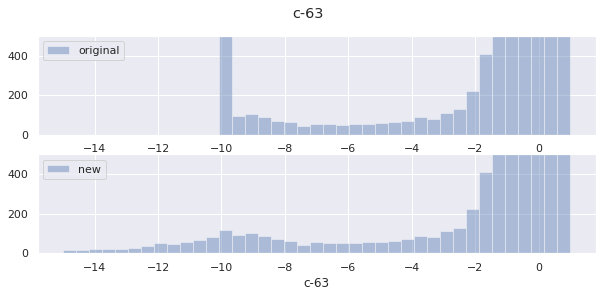

In [199]:
mask = train_features[name] < 1
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
fig.suptitle(name)

sns.distplot(train_features[name][mask], kde=False, bins=range_bin_width, ax=axs[0], label='original')
axs[0].legend(loc='upper left')
axs[0].set_ylim(0, 500)
sns.distplot(train_features_new[name][mask], kde=False, bins=range_bin_width, ax=axs[1], label='new')
axs[1].legend(loc='upper left')
axs[1].set_ylim(0, 500)